In [5]:
import numpy as np
import pandas as pd
import time
import datetime
from matplotlib import pyplot as plt
import re
import importlib

import data_preprocessing as prep

importlib.reload(prep)

<module 'data_preprocessing' from 'c:\\Users\\bmk1bj\\Documents\\GIT_repositories\\AIMatch\\data_preprocessing.py'>

#### Ideas:

- how to prefer recent matches?

### Load and preprocess data

In [6]:
df = prep.load_raw_data()
df = prep.preprocess_data(df, 
        drop_columns=["city", "country", "tournament", "neutral", "date"], 
        strip_columns=["home_team", "away_team", "tournament"])
display(df)

AttributeError: module 'data_preprocessing' has no attribute 'load_raw_data'

### Split labeled and unlabeled data

In [ ]:
df_labeled = df[df.home_score.notnull()]
df_test = df[df.home_score.isnull()]

In [ ]:
def is_test_team(match, teams):
    return match["home_team"] in teams or match["away_team"] in teams

teams_test = set([team for team in set(df_test.home_team.unique().tolist() + df_test.away_team.unique().tolist()) if not ("group" in team.lower() or "match" in team.lower())])
print(teams_test, len(teams_test))

df_labeled_testonly = df_labeled[df_labeled.apply(lambda x: is_test_team(x, teams_test), axis=1)]
df_test_testonly = df_test[df_test.apply(lambda x: is_test_team(x, teams_test), axis=1)]

print("Number of relevant matches: ", len(df_labeled_testonly))

{'Cameroon', 'Croatia', 'Iran', 'Australia', 'Qatar', 'Germany', 'Belgium', 'Wales', 'Mexico', 'Saudi Arabia', 'Japan', 'France', 'Spain', 'England', 'Costa Rica', 'Serbia', 'Argentina', 'Portugal', 'Tunisia', 'Brazil', 'Denmark', 'Uruguay', 'Switzerland', 'Netherlands', 'Senegal', 'United States', 'South Korea', 'Ghana', 'Poland', 'Canada', 'Morocco', 'Ecuador'} 32
Number of relevant matches:  18532


### Data vectorization

In [ ]:
def onehot_encode(all_categories, category):
    onehot = np.zeros(len(all_categories))
    onehot[all_categories.index(category)] = 1
    return onehot

# Teams
all_teams = sorted(list(set(list(teams_test) + [team for team in set(df_labeled_testonly.home_team.unique().tolist() + df_labeled_testonly.away_team.unique().tolist())])))
team_to_onehot = dict((team, onehot_encode(all_teams, team)) for team in all_teams)

# Tournament groups
all_tournament_groups = sorted(df.tournament_group.unique().tolist())
tournament_group_to_onehot = dict((tg, onehot_encode(all_tournament_groups, tg)) for tg in all_tournament_groups)



In [ ]:
def prepare_input_data(df: pd.DataFrame):
    X = np.vstack(df.home_team.apply(lambda x: team_to_onehot[x]))
    X = np.hstack([X, np.vstack(df.away_team.apply(lambda x: team_to_onehot[x]))])
    X = np.hstack([X, np.vstack(df.tournament_group.apply(lambda x: tournament_group_to_onehot[x]))])
    X = np.hstack([X, np.vstack(df.home_advantage)])

    Y = np.hstack([np.vstack(df.home_score), np.vstack(df.away_score)])
    # Apply y = [goal difference (home-away), winner_goals] instead of exact score [home_goals, away_goals]
    #Y = np.hstack((np.vstack(Y[:, 0] - Y[:, 1]), np.vstack(np.max(Y, axis = 1))))

    print("X shape = ", X.shape)
    print("Y shape = ", Y.shape)

    return X, Y

X_labeled, Y_labeled = prepare_input_data(df_labeled_testonly)
X_test, _ = prepare_input_data(df_test_testonly)

X shape =  (18532, 457)
Y shape =  (18532, 2)
X shape =  (48, 457)
Y shape =  (48, 2)


## Split data

In [ ]:
# Train x val split
trainval_split = 0.7
trainval_split_index = int(len(X_labeled) * trainval_split)

X_train, Y_train = X_labeled[:trainval_split_index], Y_labeled[:trainval_split_index]
X_val, Y_val = X_labeled[trainval_split_index:], Y_labeled[trainval_split_index:]

## Final score

In [ ]:
def score_sample(y, y_gt):
    """ 
    Scoring according to the AI match rules
    y = predictions
    y_gt = ground truth 
    """

    if y[0] == y_gt[0] and y[1] == y_gt[1]:
        return 4
    
    if y[0] == y_gt[0] and not y[0] == 0:
        return 3

    if (y[0] >= 0 and y_gt[0] >= 0) or (y[0] < 0 and y_gt[0] < 0):
        return 2   

    return 0

def score(Y, Y_gt):
    return np.sum([score_sample(Y[i], Y_gt[i]) for i in range(len(Y))])


In [ ]:
# Reference values
# = total score for validation data if results are hard-coded and all same without any prediction
# all models should overcome those values
max_score = 4 * len(Y_val)
ref_score_1 = score(np.zeros(Y_val.shape), Y_val) # 0:0
print("0:0", ref_score_1, "/", max_score, " - %s points per match" % (np.round(ref_score_1/len(Y_val), 2)))
ref_score_2 = score(np.ones(Y_val.shape), Y_val) # 1:0
print("1:0", ref_score_2, "/", max_score, " - %s points per match" % (np.round(ref_score_2/len(Y_val), 2)))
Y_pred = np.ones(Y_val.shape) # 1:1
Y_pred[:, 0] = 0
ref_score_3 = score(Y_pred, Y_val) 
print("1:1", ref_score_3, "/", max_score, " - %s points per match" % (np.round(ref_score_3/len(Y_val), 2)))
Y_pred = np.ones(Y_val.shape) # 0:1
Y_pred[:, 0] = -1
ref_score_3 = score(Y_pred, Y_val) 
print("0:1", ref_score_3, "/", max_score, " - %s points per match" % (np.round(ref_score_3/len(Y_val), 2)))
Y_pred = np.ones(Y_val.shape) # 2:1
Y_pred[:, 1] = 2
ref_score_3 = score(Y_pred, Y_val) 
print("2:1", ref_score_3, "/", max_score, " - %s points per match" % (np.round(ref_score_3/len(Y_val), 2)))
Y_pred = 2 * np.ones(Y_val.shape) # 2:0
ref_score_3 = score(Y_pred, Y_val) 
print("2:0", ref_score_3, "/", max_score, " - %s points per match" % (np.round(ref_score_3/len(Y_val), 2)))

0:0 8856 / 22240  - 1.59 points per match
1:0 9656 / 22240  - 1.74 points per match
1:1 9020 / 22240  - 1.62 points per match
0:1 4560 / 22240  - 0.82 points per match
2:1 9460 / 22240  - 1.7 points per match
2:0 9033 / 22240  - 1.62 points per match


In [ ]:
def prediction_to_goals(y):
    """ Encoding back to the exact result 
    [goal_diff, home_goals] -> [home_goals, away_goals]
    """
    return np.hstack([y[1], y[1] - y[0]])

def predictions_to_goals(Y):
    """ Encoding back to the exact result for whole data set
    [goal_diff, home_goals] -> [home_goals, away_goals]
    """
    return np.vstack([prediction_to_goals(Y[i]) for i in range(len(Y))])

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor



def show_predictions(X, Y, Y_pred, indexes):
    for i in indexes:
        x = X[i]
        home_team_part = x[:len(all_teams)]
        away_team_part = x[len(all_teams):2*len(all_teams)]
        home_team = all_teams[np.where(home_team_part == 1)[0][0]]
        away_team = all_teams[np.where(away_team_part == 1)[0][0]]
        print(home_team, " x ", away_team, ": ", prediction_to_goals(Y_pred[i]), "-", prediction_to_goals(Y[i]))


def fit_simple_regressor(X_train, Y_train, X_val, Y_val, regressor, name: str, show_predicted_indexes = [0, 1, 2, 3, 4]):
    regressor.fit(X_train, Y_train)
    Y_val_pred = regressor.predict(X_val)
    Y_test_pred = regressor.predict(X_test)
    reg_score = score(np.round(Y_val_pred), Y_val)
    print(name)
    print(reg_score, "/", max_score, " - %s points per match" % (np.round(reg_score/len(Y_val), 2)))
    
    show_predictions(X_val, Y_val, Y_val_pred, show_predicted_indexes)
    print("Test")
    show_predictions(X_test, np.zeros(Y_test_pred.shape), Y_test_pred, show_predicted_indexes)
    


models = {
    "Tree": DecisionTreeRegressor(random_state=0),
    "Linear": LinearRegression(),
    "MLP": MLPRegressor(hidden_layer_sizes = (64, 16))
}


trainable = 0.1
start = int((1 - trainable) * len(X_train))
for name, model in models. items():
    fit_simple_regressor(X_train[start:], Y_train[start:], X_val, Y_val, model, name)


Tree
8834 / 22240  - 1.59 points per match
Morocco  x  Zimbabwe :  [2.5 0. ] - [1. 0.]
Senegal  x  DR Congo :  [2. 1.] - [0. 0.]
Tunisia  x  Ghana :  [2. 2.] - [2. 0.]
Morocco  x  Angola :  [3. 1.] - [2. 2.]
Saudi Arabia  x  Sweden :  [1. 1.] - [1. 1.]
Test
Qatar  x  Ecuador :  [2. 2.] - [0. 0.]
England  x  Iran :  [1. 1.] - [0. 0.]
Senegal  x  Netherlands :  [2. 2.] - [0. 0.]
United States  x  Wales :  [2. 0.] - [0. 0.]
Argentina  x  Saudi Arabia :  [1. 0.] - [0. 0.]
Linear
9495 / 22240  - 1.71 points per match
Morocco  x  Zimbabwe :  [5.36328125 2.62890625] - [1. 0.]
Senegal  x  DR Congo :  [ 1.8046875 -0.265625 ] - [0. 0.]
Tunisia  x  Ghana :  [1.22265625 0.91015625] - [2. 0.]
Morocco  x  Angola :  [2.4296875 0.4453125] - [2. 2.]
Saudi Arabia  x  Sweden :  [1.27734375 2.59765625] - [1. 1.]
Test
Qatar  x  Ecuador :  [2.30859375 2.10546875] - [0. 0.]
England  x  Iran :  [2.1640625 0.7890625] - [0. 0.]
Senegal  x  Netherlands :  [0.984375 2.546875] - [0. 0.]
United States  x  Wales :  

c:\Users\bmk1bj\.conda\envs\aimatch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
# Assign weights to samples
dataset = prep.Dataset()
X_train, Y_train, X_val, Y_val, X_test = dataset.get_input_data() # see which parameters can be modified

Number of relevant labeled matches: 18532/44060
X shape =  (18532, 457)
Y shape =  (18532, 2)
X shape =  (48, 457)
Y shape =  (48, 2)


In [25]:
importlib.reload(prep)
X_train, Y_train, X_val, Y_val, X_test, sample_weights_train, sample_weights_val = prep.Dataset().get_input_data(sample_weights_degree=2) # see which parameters can be modified

Number of relevant labeled matches: 18532/44060


KeyError: 'sample_weights'

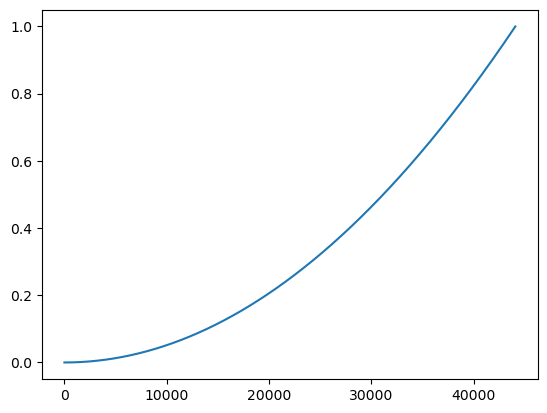

In [23]:
importlib.reload(prep)
dataset.df_labeled = prep.add_sample_weights(dataset.df_labeled, degree=2)
plt.plot(dataset.df_labeled["sample_weight"])
plt.show()